In [30]:
# ================================
# Exploratory Data Analysis (EDA) for Fetal Health Dataset
# ================================

# 1. Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

# 2. Load Dataset
data = pd.read_csv("fetal_health.csv")

# 3. Basic Info
print("Dataset Shape:", data.shape)
print("\nData Types:\n", data.dtypes)
print("\nMissing Values:\n", data.isnull().sum())
print("\nDescriptive Statistics:\n", data.describe())


Dataset Shape: (2126, 22)

Data Types:
 baseline value                                            float64
accelerations                                             float64
fetal_movement                                            float64
uterine_contractions                                      float64
light_decelerations                                       float64
severe_decelerations                                      float64
prolongued_decelerations                                  float64
abnormal_short_term_variability                           float64
mean_value_of_short_term_variability                      float64
percentage_of_time_with_abnormal_long_term_variability    float64
mean_value_of_long_term_variability                       float64
histogram_width                                           float64
histogram_min                                             float64
histogram_max                                             float64
histogram_number_of_peaks           

C:\Users\USER\AppData\Local\Temp\ipykernel_52\2233551532.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="fetal_health", data=data, palette="viridis")


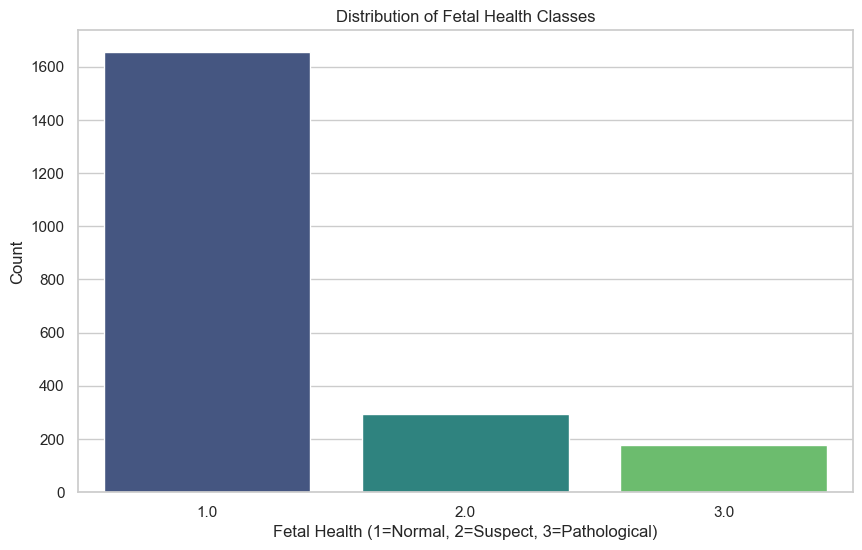


Class Balance (%):
 fetal_health
1.0    77.845720
2.0    13.875823
3.0     8.278457
Name: proportion, dtype: float64


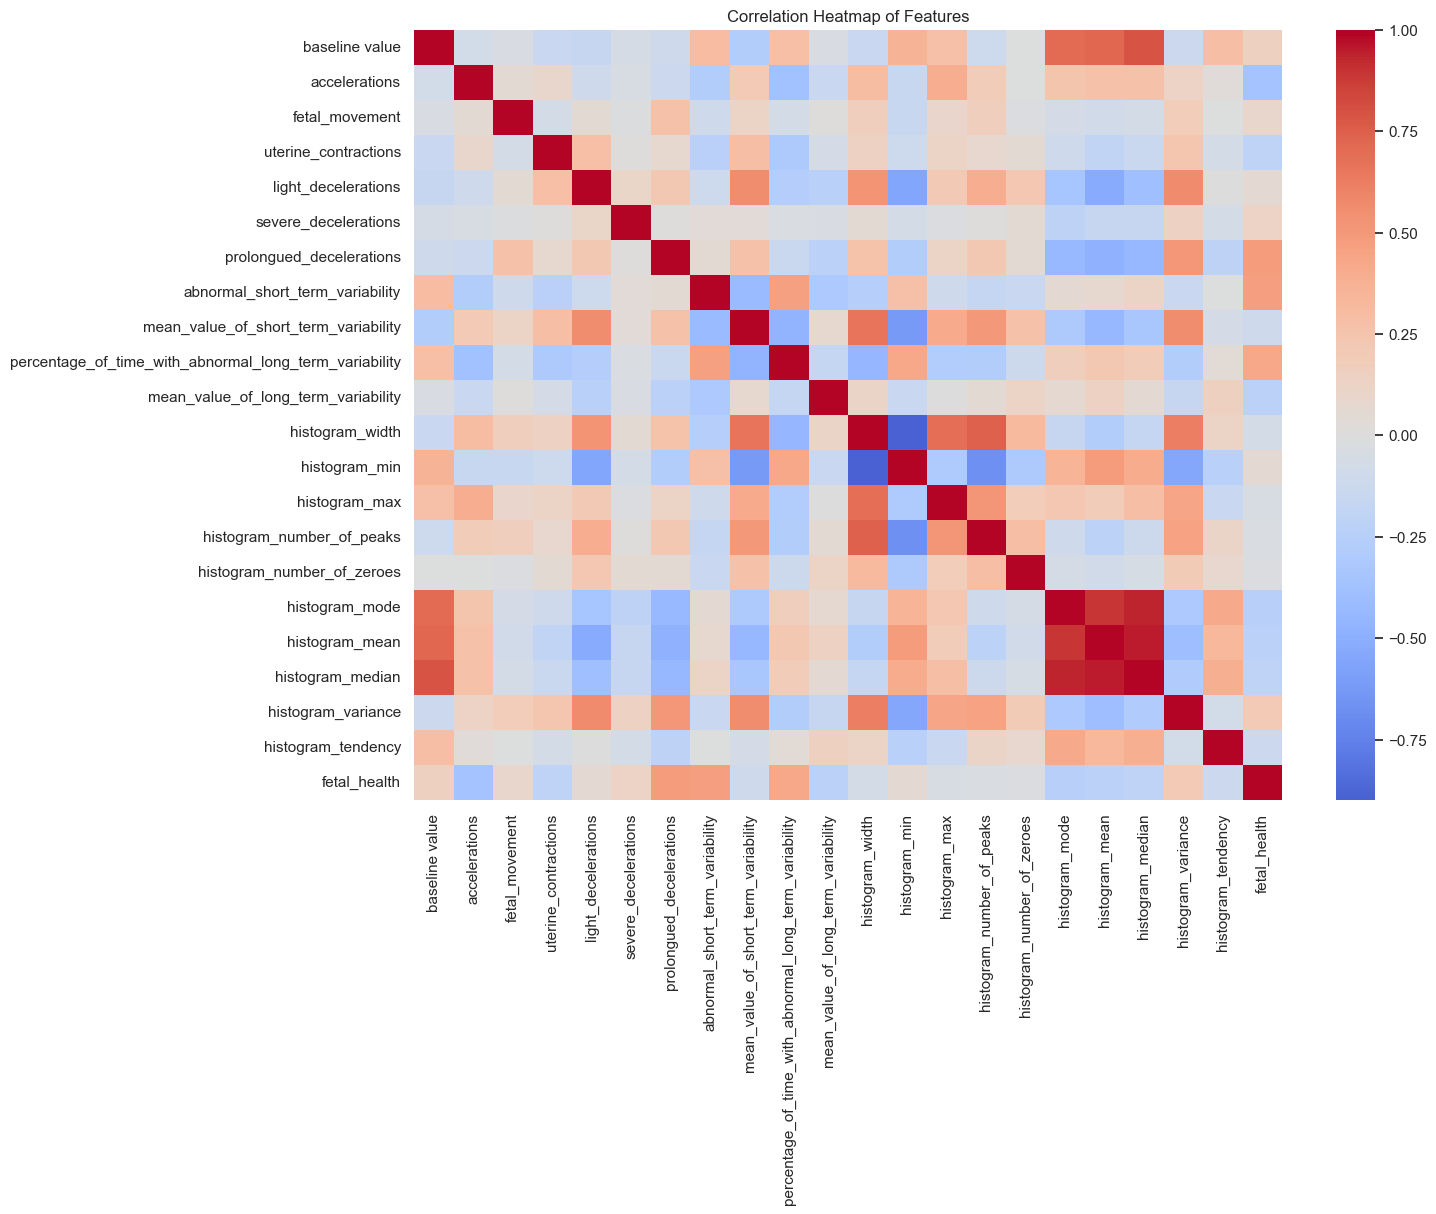

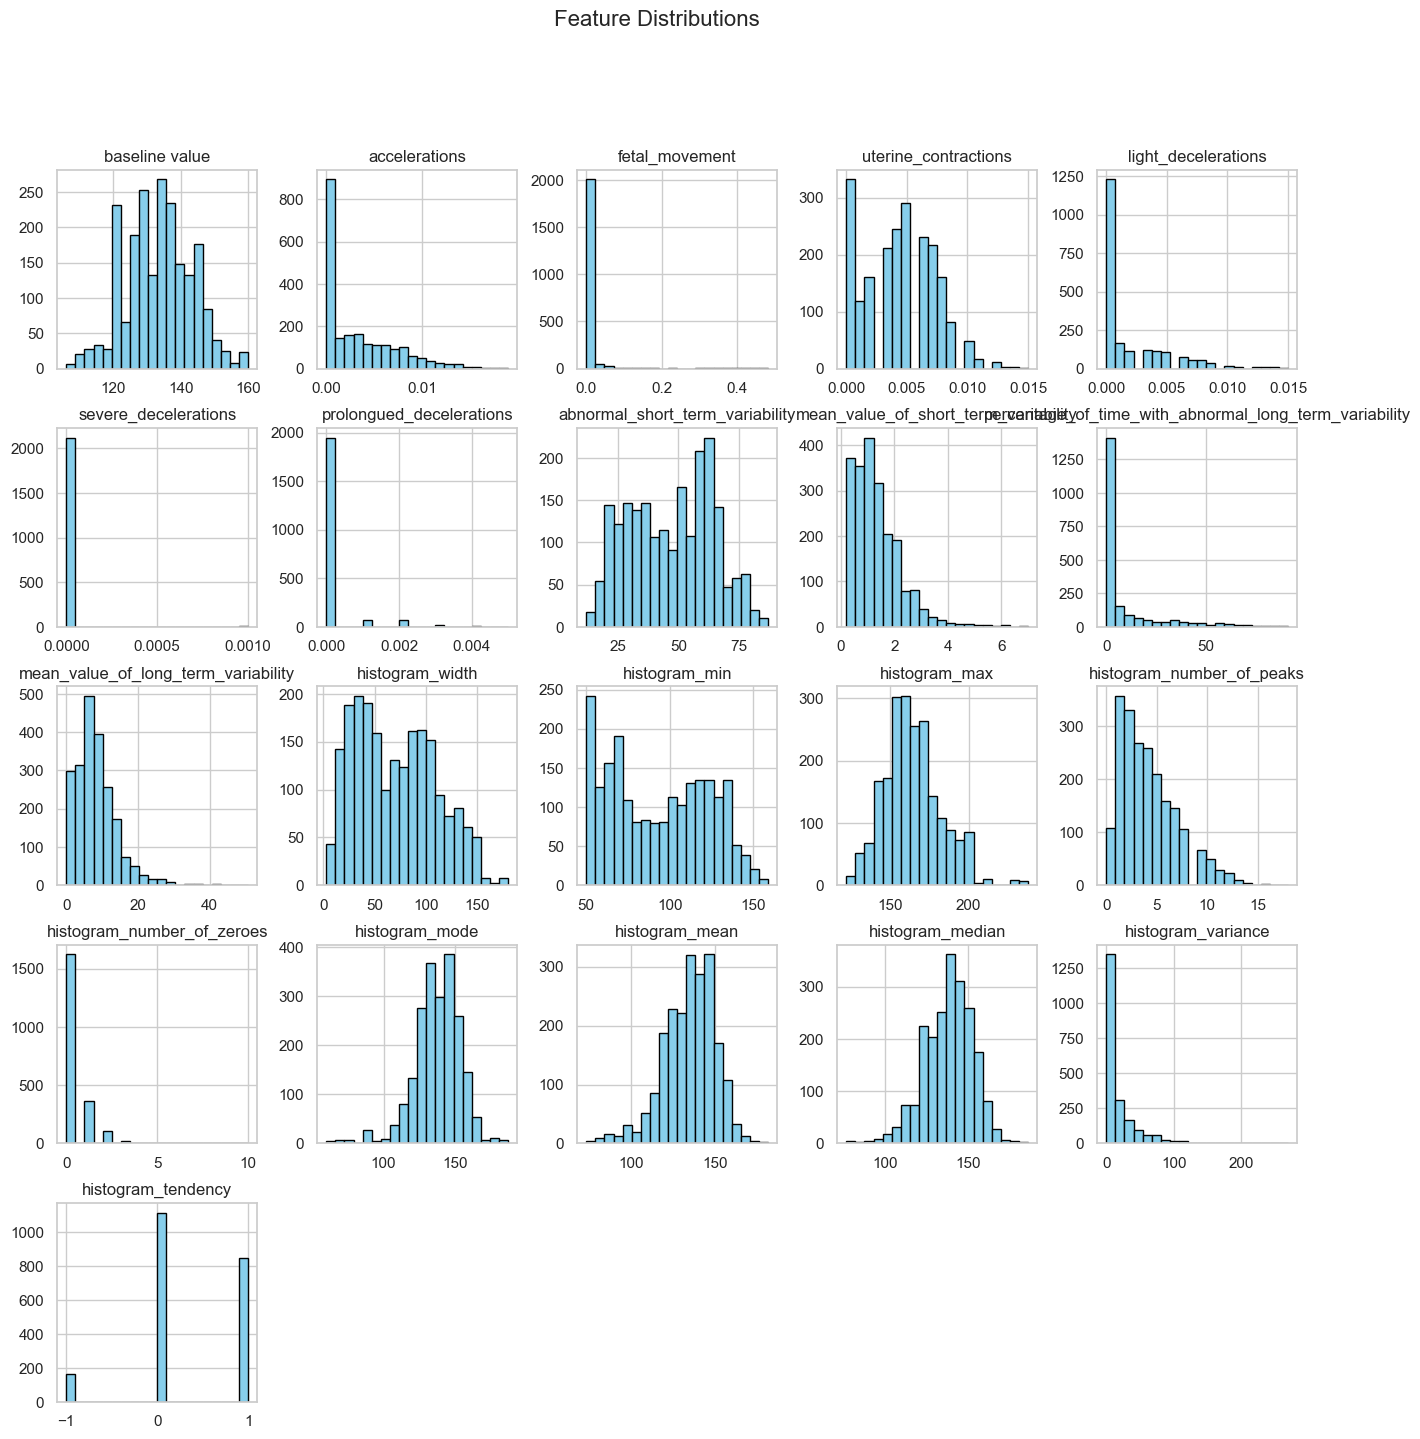

In [31]:
# 4. Target Variable Distribution
sns.countplot(x="fetal_health", data=data, palette="viridis")
plt.title("Distribution of Fetal Health Classes")
plt.xlabel("Fetal Health (1=Normal, 2=Suspect, 3=Pathological)")
plt.ylabel("Count")
plt.show()

print("\nClass Balance (%):\n", data["fetal_health"].value_counts(normalize=True)*100)

# 5. Correlation Heatmap
plt.figure(figsize=(14,10))
corr = data.corr()
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, cbar=True)
plt.title("Correlation Heatmap of Features")
plt.show()

# 6. Feature Distributions
num_features = data.drop(columns=["fetal_health"]).columns

data[num_features].hist(bins=20, figsize=(16,16), color="skyblue", edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


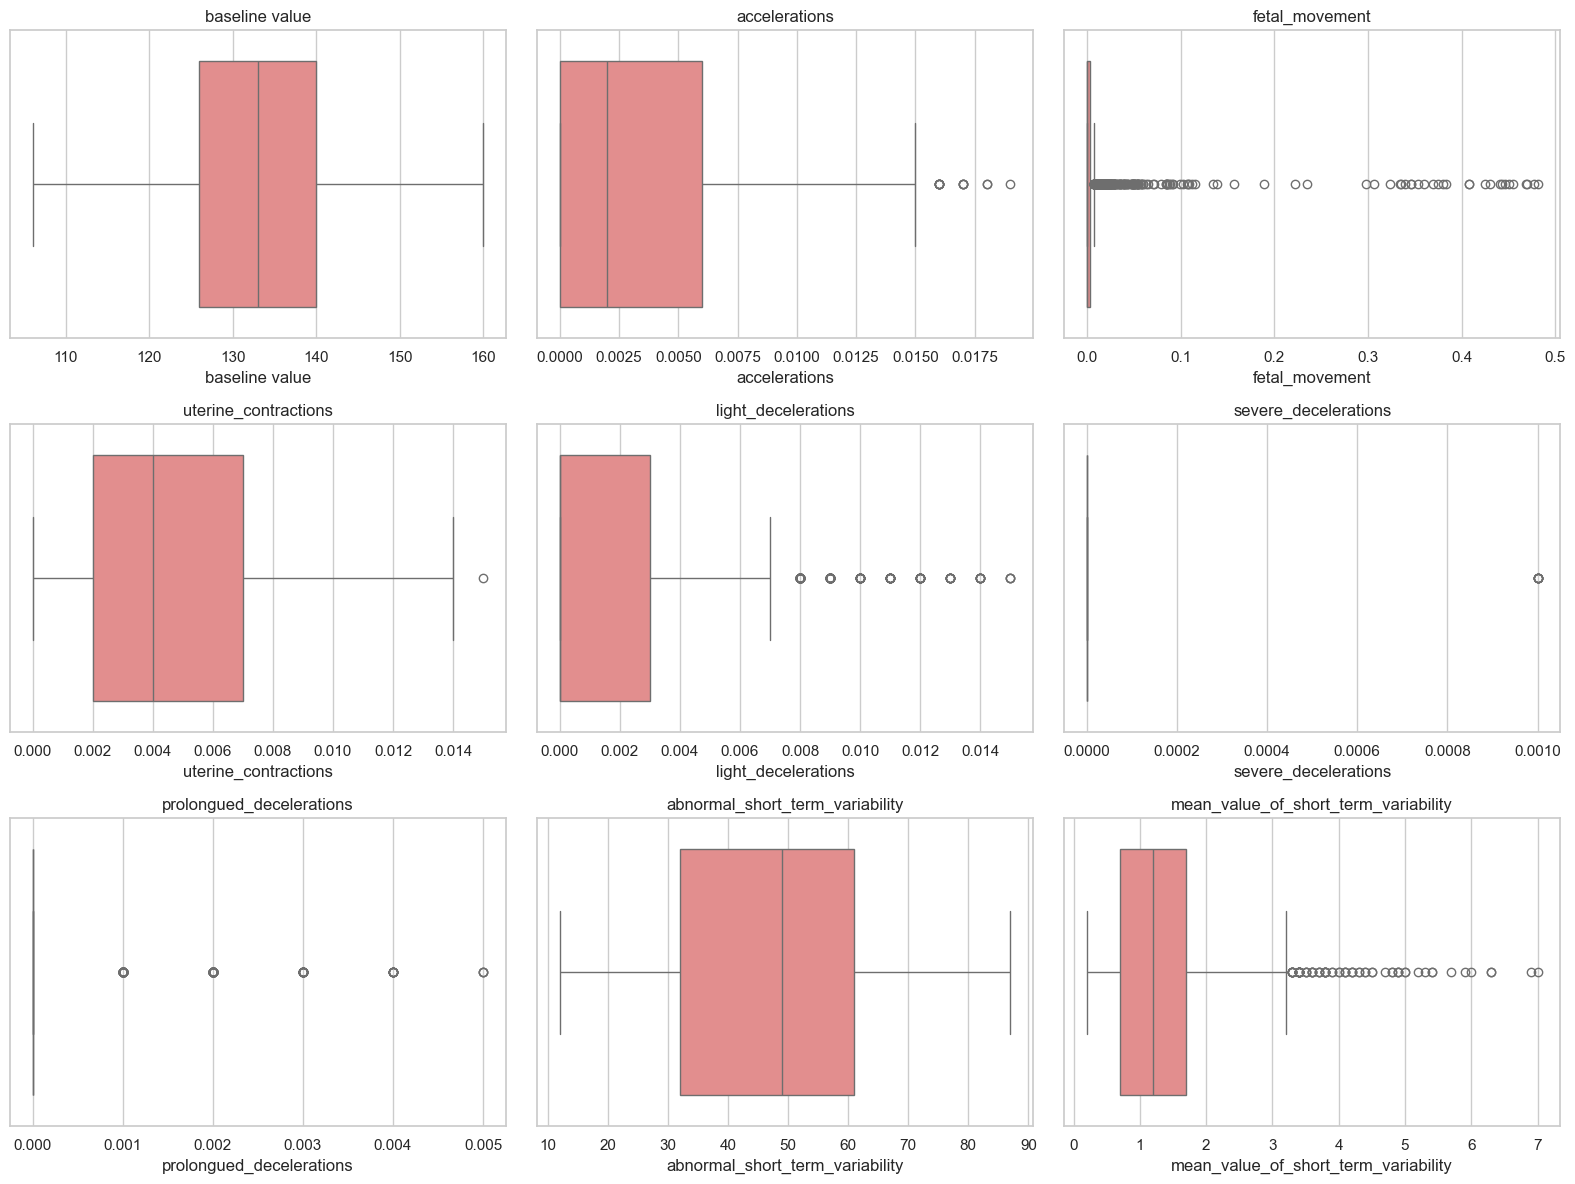

C:\Users\USER\AppData\Local\Temp\ipykernel_52\1600554952.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="fetal_health", y=col, data=data, palette="Set2")
C:\Users\USER\AppData\Local\Temp\ipykernel_52\1600554952.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="fetal_health", y=col, data=data, palette="Set2")
C:\Users\USER\AppData\Local\Temp\ipykernel_52\1600554952.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="fetal_health", y=col, data=data, palette="Set2")
C:\Users\USER\AppData\Local\Temp\ipykernel_52\1600554952.py:1

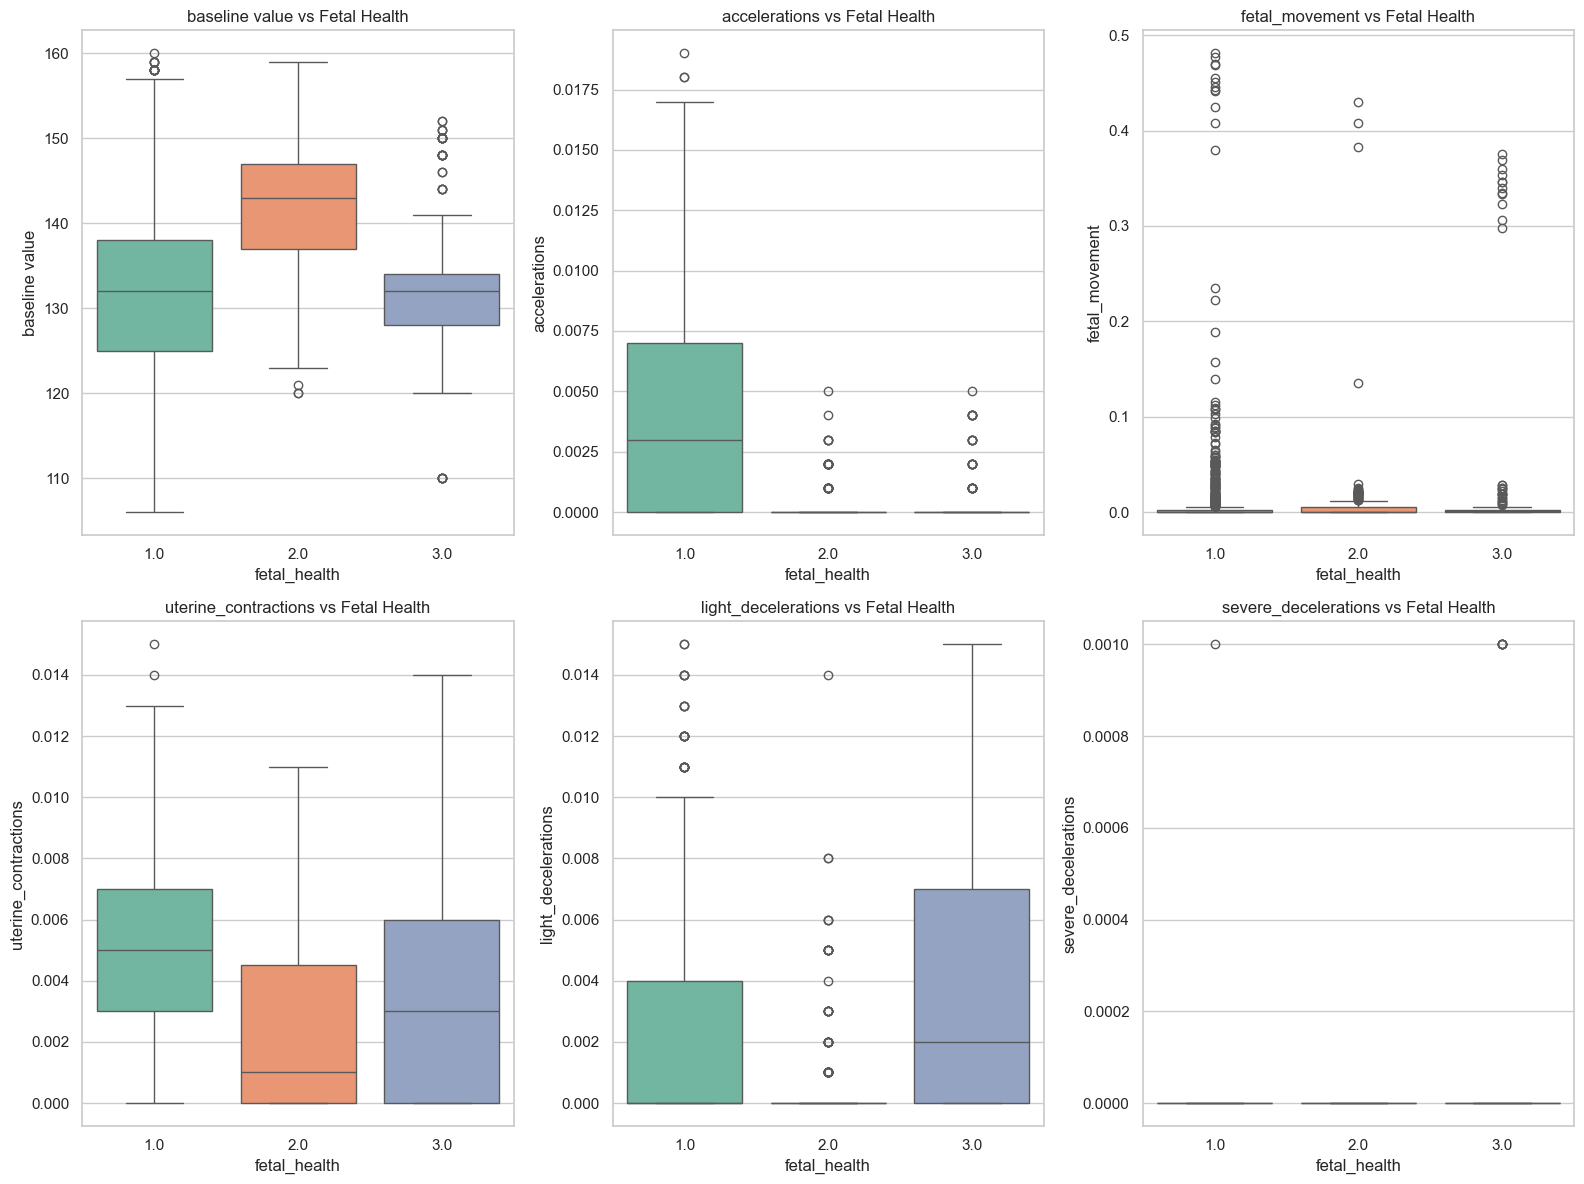

In [32]:
# 7. Boxplots for Outlier Detection
plt.figure(figsize=(16,12))
for i, col in enumerate(num_features[:9], 1):  # show first 9 features
    plt.subplot(3,3,i)
    sns.boxplot(x=data[col], color="lightcoral")
    plt.title(col)
plt.tight_layout()
plt.show()

# 8. Features vs Target
plt.figure(figsize=(16,12))
for i, col in enumerate(num_features[:6], 1):  # show first 6 features
    plt.subplot(2,3,i)
    sns.boxplot(x="fetal_health", y=col, data=data, palette="Set2")
    plt.title(f"{col} vs Fetal Health")
plt.tight_layout()
plt.show()

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical

# Features and target
X = data.drop("fetal_health", axis=1)
y = data["fetal_health"]

# Train-test split (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Resample (SMOTE for class balance)
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# One-hot encode target
y_train_encoded = to_categorical(y_train_resampled - 1)  # shift {1,2,3} → {0,1,2}
y_test_encoded = to_categorical(y_test - 1)


In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# One-hot encode target (important for multiclass classification)
y_train_encoded = to_categorical(y_train_resampled - 1)  # classes {1,2,3} → {0,1,2}
y_test_encoded = to_categorical(y_test - 1)

# Define the model
model = Sequential([
    Dense(128, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # 3 output classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # for multiclass
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_scaled,
    y_train_encoded,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.5052 - loss: 1.0292 - val_accuracy: 0.5381 - val_loss: 1.1470
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7876 - loss: 0.6825 - val_accuracy: 0.6288 - val_loss: 0.9107
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8394 - loss: 0.5061 - val_accuracy: 0.6806 - val_loss: 0.7127
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8474 - loss: 0.4360 - val_accuracy: 0.7827 - val_loss: 0.5375
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8697 - loss: 0.3965 - val_accuracy: 0.7928 - val_loss: 0.5108
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8814 - loss: 0.3538 - val_accuracy: 0.8115 - val_loss: 0.4372
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8748 - loss: 0.3354 - val_accuracy: 0.8129 - val_loss: 0.4284
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8775 - loss: 0.3264 - val_accuracy: 0.8532 -

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Confusion Matrix:
[[459  36   2]
 [ 13  73   2]
 [  5   4  44]]


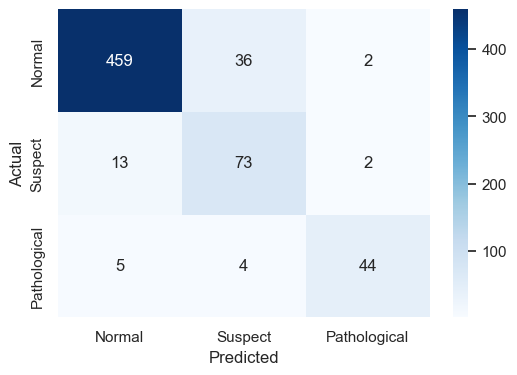


Classification Report:
              precision    recall  f1-score   support

      Normal     0.9623    0.9235    0.9425       497
     Suspect     0.6460    0.8295    0.7264        88
Pathological     0.9167    0.8302    0.8713        53

    accuracy                         0.9028       638
   macro avg     0.8416    0.8611    0.8467       638
weighted avg     0.9149    0.9028    0.9068       638

Precision (macro): 0.8416
Recall (macro): 0.8611
F1 Score (macro): 0.8467
ROC AUC: 0.9746
PR AUC: 0.8830


In [37]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_pred_probs = model.predict(X_test_scaled)  # probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1) + 1  # {0,1,2} → {1,2,3}

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Suspect", "Pathological"],
            yticklabels=["Normal", "Suspect", "Pathological"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
report = classification_report(y_test, y_pred_classes, target_names=["Normal", "Suspect", "Pathological"], digits=4)
print("\nClassification Report:")
print(report)

# Precision, Recall, F1 (macro-averaged)
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred_classes, average="macro")
recall = recall_score(y_test, y_pred_classes, average="macro")
f1 = f1_score(y_test, y_pred_classes, average="macro")

print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")

# ROC AUC (One-vs-Rest for multiclass)
roc_auc = roc_auc_score(to_categorical(y_test - 1), y_pred_probs, multi_class="ovr")
print(f"ROC AUC: {roc_auc:.4f}")

# PR AUC (macro average)
pr_auc = average_precision_score(to_categorical(y_test - 1), y_pred_probs, average="macro")
print(f"PR AUC: {pr_auc:.4f}")